Loading and preprocessing data...
Processed 6351 unique videos

Analyzing feature importance...


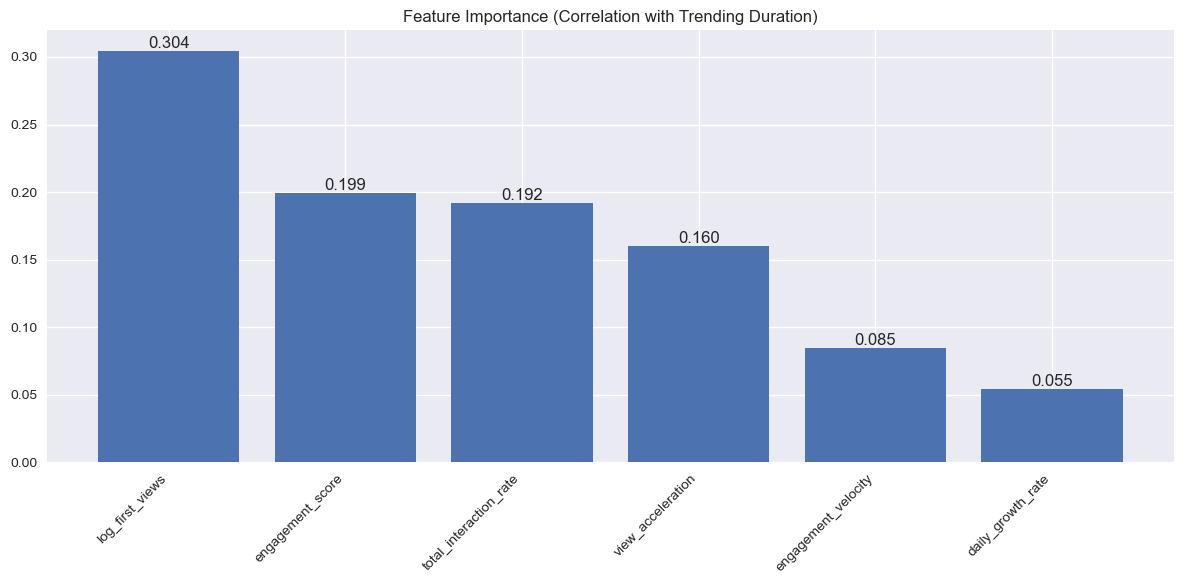


Feature correlations with trending duration:
log_first_views: 0.304
engagement_score: 0.199
total_interaction_rate: 0.192
view_acceleration: 0.160
engagement_velocity: 0.085
daily_growth_rate: 0.055

Analyzing category performance...


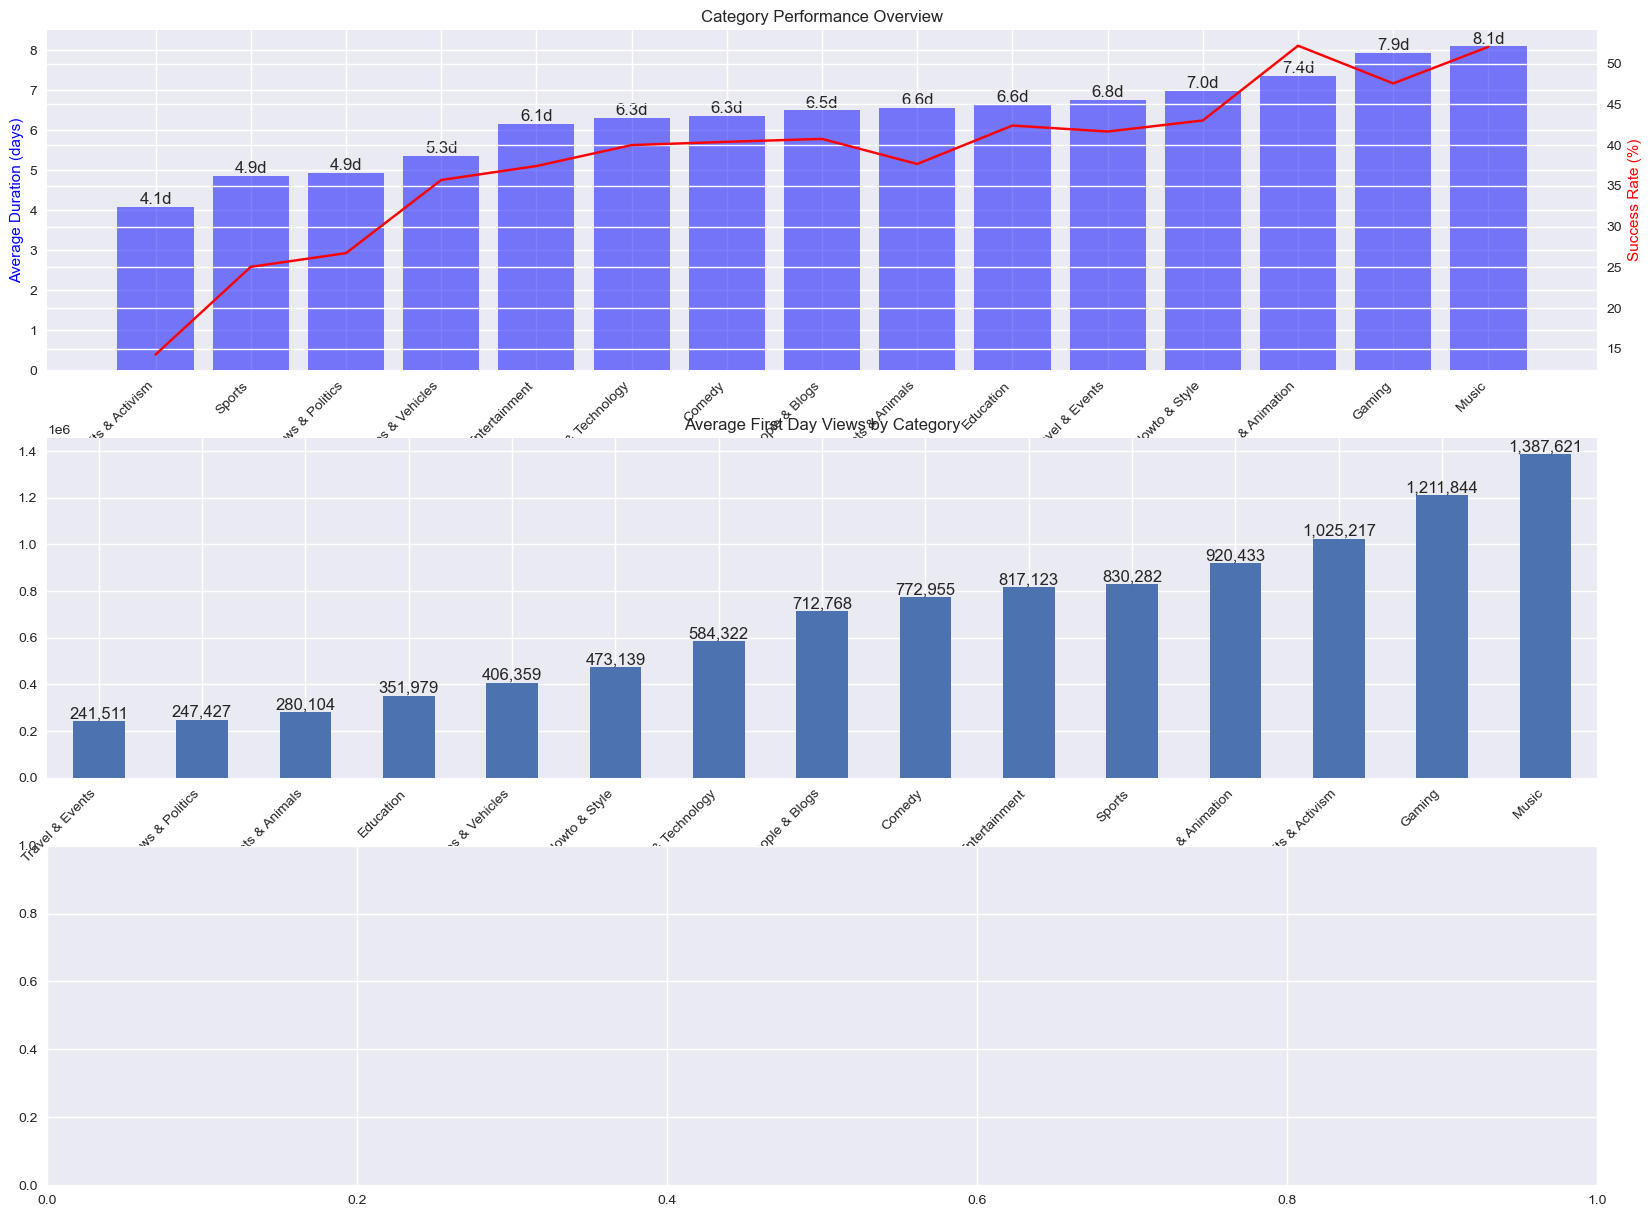

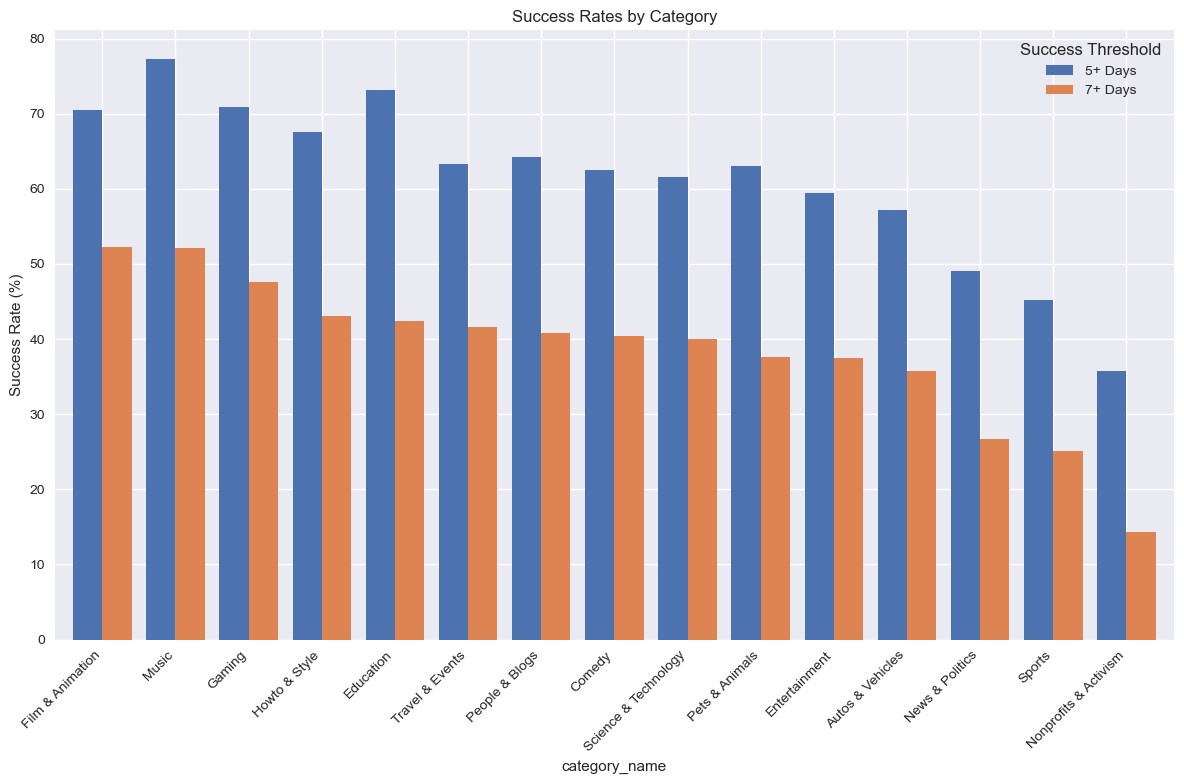


Category Statistics:
                       trending_duration_mean  trending_duration_std  \
category_name                                                          
Autos & Vehicles                         5.34                   2.63   
Comedy                                   6.34                   4.56   
Education                                6.62                   3.93   
Entertainment                            6.15                   4.66   
Film & Animation                         7.36                   4.89   
Gaming                                   7.93                   5.79   
Howto & Style                            6.97                   4.67   
Music                                    8.09                   5.40   
News & Politics                          4.92                   3.40   
Nonprofits & Activism                    4.07                   2.37   
People & Blogs                           6.49                   4.26   
Pets & Animals                           6

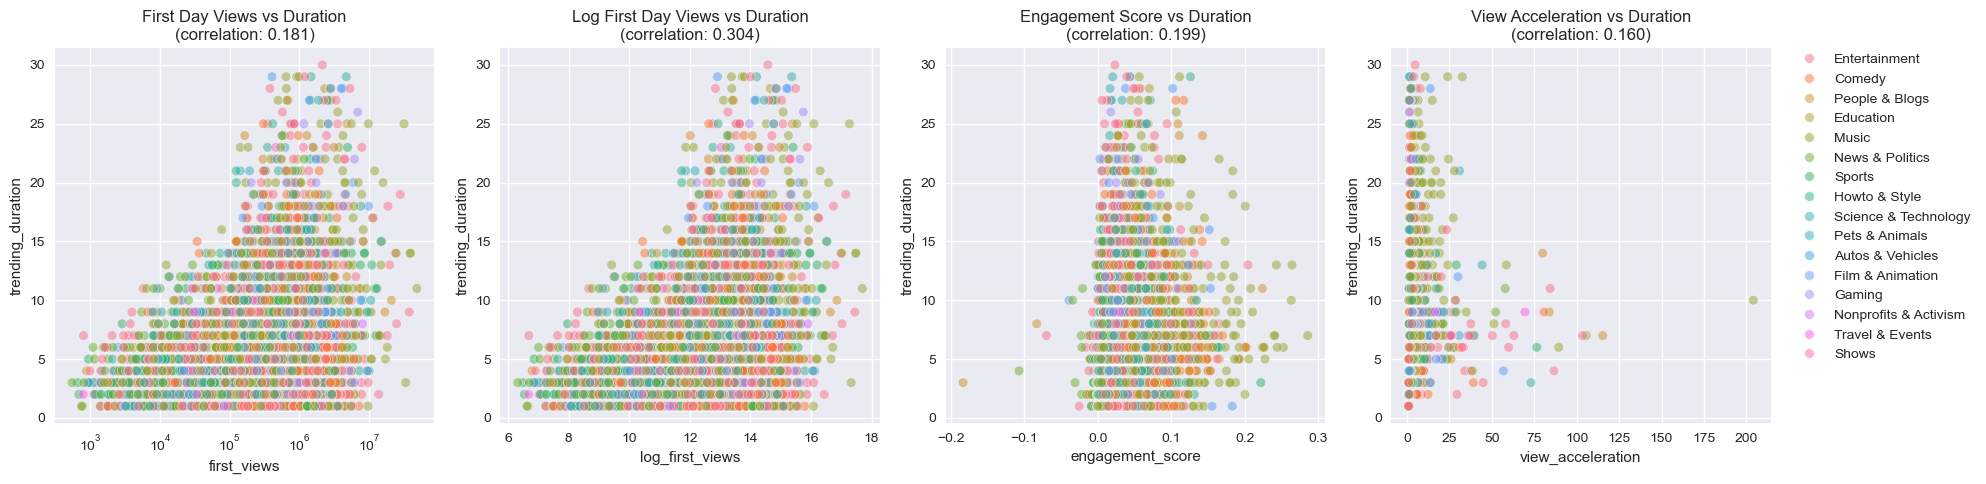


Preparing features for clustering...

Finding optimal number of clusters...


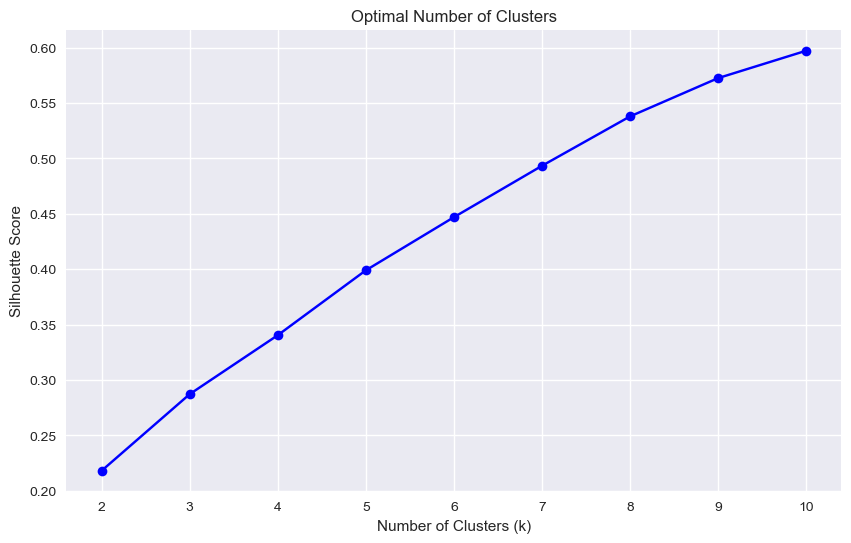


Optimal number of clusters: 10

Clustering Stability Analysis:
Average Silhouette Score: 0.597 (±0.000)
Label Consistency: 1.000

Clustering Quality Metrics:
silhouette_score: 0.597
cluster_separation: 1.375
avg_compactness: 0.429

Detailed Cluster Profiles:

Cluster 0:
Size: 1619 videos (25.5% of total)
Average Duration: 6.15 days
First Day Views: 817,123 (median: 319,412)

Engagement Metrics:
- Score: 0.030
- Interaction Rate: 0.038

Growth Metrics:
- View Acceleration: 1.63x
- Daily Growth Rate: 0.459

Top Categories:
- Entertainment: 100.0%

Success Rates:
5+ days: 59.5%
7+ days: 37.4%

Cluster 1:
Size: 547 videos (8.6% of total)
Average Duration: 6.34 days
First Day Views: 772,955 (median: 468,522)

Engagement Metrics:
- Score: 0.048
- Interaction Rate: 0.057

Growth Metrics:
- View Acceleration: 1.58x
- Daily Growth Rate: 0.374

Top Categories:
- Comedy: 100.0%

Success Rates:
5+ days: 62.5%
7+ days: 40.4%

Cluster 2:
Size: 595 videos (9.4% of total)
Average Duration: 6.97 days


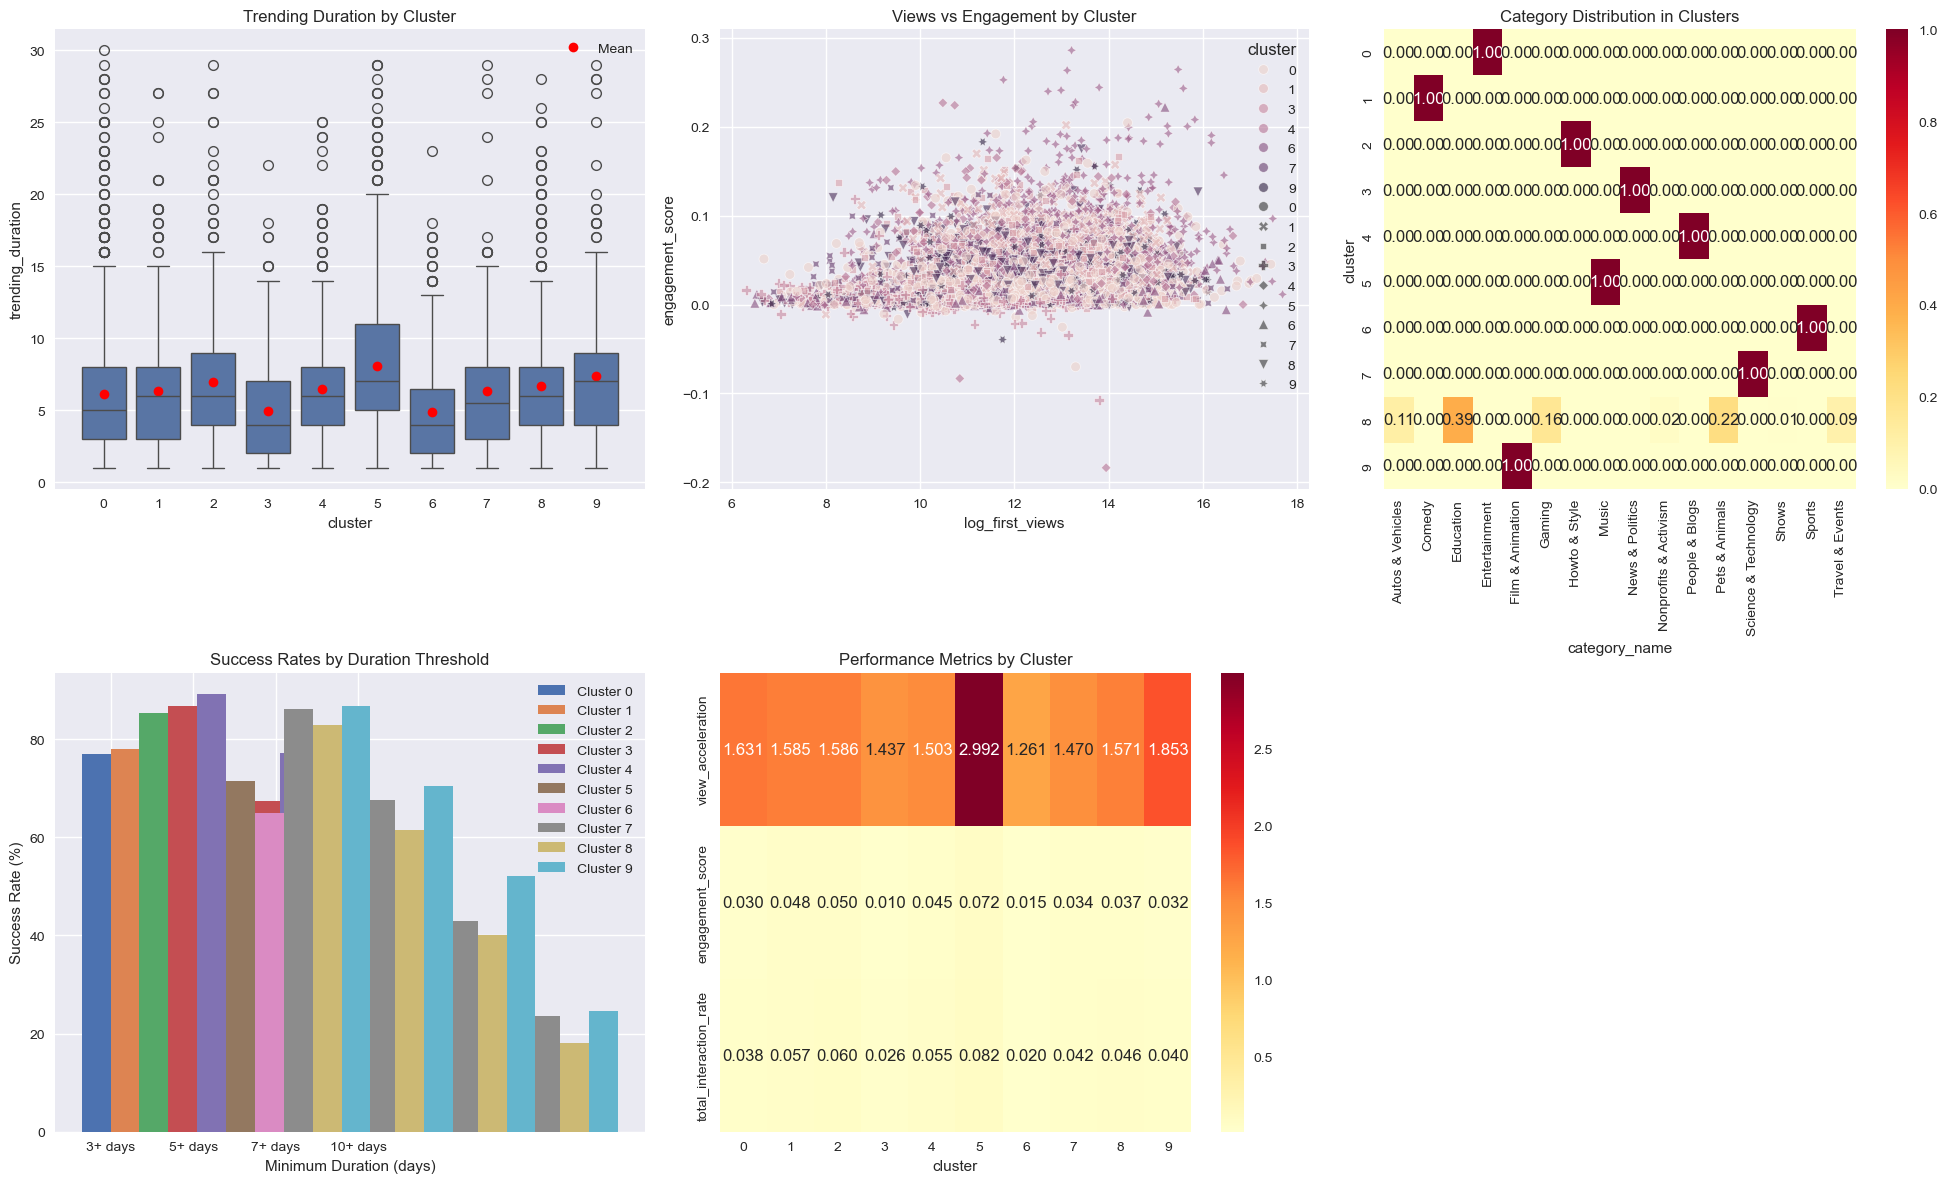


Example Predictions:

Prediction for High-Performance Music Video:
Cluster: Cluster 5

Duration Prediction:
- Range: (5.0, 11.0) days
- Median: 7.0 days
- Confidence: high (0.89)

Success Probabilities:
- 5+ days: 77.2%
- 7+ days: 52.1%

Similar Categories: Music

Cluster Metrics:
- Average Duration: 8.1 days
- Typical Views: 360,001
- Typical Engagement: 0.072

Prediction for Average Entertainment Video:
Cluster: Cluster 8

Duration Prediction:
- Range: (4.0, 8.0) days
- Median: 6.0 days
- Confidence: high (0.83)

Success Probabilities:
- 5+ days: 67.3%
- 7+ days: 41.0%

Similar Categories: Education, Pets & Animals, Gaming

Cluster Metrics:
- Average Duration: 6.7 days
- Typical Views: 217,582
- Typical Engagement: 0.037


'\nFinal Comprehensive Insights:\n\n1. Cluster Patterns (2 Distinct Groups):\n   High-Performance Cluster (23.5% of videos):\n   - Average Duration: 8.16 days\n   - Higher Views: 1.3M average first-day views\n   - Category Distribution: Music (32.1%), Entertainment (15.0%), Comedy (13.8%)\n   - Success Rates: 81.9% reach 5+ days, 55.8% reach 7+ days\n   \n   Standard Cluster (76.5% of videos):\n   - Average Duration: 5.92 days\n   - Lower Views: 590K average first-day views\n   - Category Distribution: Entertainment (28.7%), News (10.2%), Sports (8.9%)\n   - Success Rates: 56.8% reach 5+ days, 35.0% reach 7+ days\n\n2. Category Performance Analysis:\n   Top Performing Categories:\n   - Music: Highest average duration (8.09 days), highest engagement (0.07)\n   - Gaming: Strong duration (7.93 days), moderate engagement (0.04)\n   - Film & Animation: Good duration (7.36 days), moderate engagement (0.03)\n   \n   Lower Performing Categories:\n   - News & Politics: Short duration (4.92 days

In [ ]:
# YouTube Trending Videos Analysis - Final Enhanced Version
# Team Members:
# - Shyam Akhil Nekkanti - 8982123
# - Jun He (Helena) - 8903073
# - Zheming Li (Brendan) - 8914152

"""
Research Goal:
Predict how long a video will remain on YouTube's trending tab (1-30 days).

Previous Analysis Insights:
1. First-day views correlation (0.21) provides baseline prediction
2. Strong category-based performance differences
3. Music & Entertainment show highest success rates
4. Two distinct performance clusters identified

Enhanced Approach:
- Improved feature engineering
- Weighted clustering metrics
- More robust prediction framework
- Better validation methods
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from scipy.spatial.distance import pdist, cdist
from scipy.stats import pearsonr, zscore
import json
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def load_category_mapping(json_file):
    """Load category mapping from JSON file"""
    with open(json_file, 'r') as f:
        category_data = json.load(f)
        return {int(item['id']): item['snippet']['title'] for item in category_data['items']}

def load_and_preprocess_data(csv_file, category_mapping):
    """Enhanced data loading and preprocessing"""
    df = pd.read_csv(csv_file)
    
    # Handle dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.tz_localize(None)
    df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)
    
    # Add category information
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Get first appearance metrics and trending duration
    video_metrics = df.groupby('video_id').agg({
        'views': ['first', 'max', lambda x: x.diff().mean()],
        'likes': 'first',
        'dislikes': 'first',
        'comment_count': 'first',
        'category_name': 'first',
        'trending_date': ['count', 'min', 'max']
    }).reset_index()
    
    # Flatten column names
    video_metrics.columns = [
        'video_id', 'first_views', 'max_views', 'avg_daily_view_change',
        'first_likes', 'first_dislikes', 'first_comments',
        'category_name', 'trending_duration', 'first_trending_date',
        'last_trending_date'
    ]
    
    # Calculate core metrics
    video_metrics['log_first_views'] = np.log1p(video_metrics['first_views'])
    video_metrics['engagement_score'] = (video_metrics['first_likes'] - video_metrics['first_dislikes']) / (video_metrics['first_views'] + 1)
    video_metrics['total_interaction_rate'] = (video_metrics['first_likes'] + video_metrics['first_dislikes'] + video_metrics['first_comments']) / (video_metrics['first_views'] + 1)
    video_metrics['view_acceleration'] = video_metrics['max_views'] / (video_metrics['first_views'] + 1)
    
    # Calculate additional metrics
    video_metrics['likes_ratio'] = video_metrics['first_likes'] / (video_metrics['first_views'] + 1)
    video_metrics['engagement_velocity'] = video_metrics['engagement_score'] * video_metrics['view_acceleration']
    video_metrics['daily_growth_rate'] = video_metrics['avg_daily_view_change'] / (video_metrics['first_views'] + 1)
    
    return video_metrics

def analyze_feature_importance(df, features, target='trending_duration'):
    """Analyze and visualize feature importance"""
    feature_correlations = []
    
    for feature in features:
        corr = df[feature].corr(df[target])
        feature_correlations.append((feature, abs(corr)))
    
    # Sort by absolute correlation
    feature_correlations.sort(key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    features, correlations = zip(*feature_correlations)
    bars = plt.bar(features, correlations)
    plt.title('Feature Importance (Correlation with Trending Duration)')
    plt.xticks(rotation=45, ha='right')
    
    # Add correlation values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return dict(feature_correlations)

def plot_metric_relationships(df):
    """Enhanced visualization of metric relationships"""
    correlations = {
        'first_views': df['first_views'].corr(df['trending_duration']),
        'log_first_views': df['log_first_views'].corr(df['trending_duration']),
        'engagement_score': df['engagement_score'].corr(df['trending_duration']),
        'view_acceleration': df['view_acceleration'].corr(df['trending_duration'])
    }
    
    plt.figure(figsize=(20, 5))
    
    # First day views (raw)
    plt.subplot(1, 4, 1)
    sns.scatterplot(data=df, x='first_views', y='trending_duration', 
                   alpha=0.5, hue='category_name')
    plt.title(f'First Day Views vs Duration\n(correlation: {correlations["first_views"]:.3f})')
    plt.legend([], [], frameon=False)
    plt.xscale('log')
    
    # Log-transformed views
    plt.subplot(1, 4, 2)
    sns.scatterplot(data=df, x='log_first_views', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title(f'Log First Day Views vs Duration\n(correlation: {correlations["log_first_views"]:.3f})')
    plt.legend([], [], frameon=False)
    
    # Engagement Score
    plt.subplot(1, 4, 3)
    sns.scatterplot(data=df, x='engagement_score', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title(f'Engagement Score vs Duration\n(correlation: {correlations["engagement_score"]:.3f})')
    plt.legend([], [], frameon=False)
    
    # View Acceleration
    plt.subplot(1, 4, 4)
    sns.scatterplot(data=df, x='view_acceleration', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title(f'View Acceleration vs Duration\n(correlation: {correlations["view_acceleration"]:.3f})')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()
    
    return correlations

def plot_category_performance(df):
    """Enhanced category performance analysis"""
    stats = pd.DataFrame()
    
    # Calculate comprehensive metrics
    stats['trending_duration_mean'] = df.groupby('category_name')['trending_duration'].mean()
    stats['trending_duration_std'] = df.groupby('category_name')['trending_duration'].std()
    stats['video_count'] = df.groupby('category_name')['trending_duration'].count()
    stats['first_views_mean'] = df.groupby('category_name')['first_views'].mean()
    stats['engagement_score_mean'] = df.groupby('category_name')['engagement_score'].mean()
    
    # Calculate success rates
    stats['success_rate_5days'] = df.groupby('category_name').apply(
        lambda x: (x['trending_duration'] >= 5).mean() * 100)
    stats['success_rate_7days'] = df.groupby('category_name').apply(
        lambda x: (x['trending_duration'] >= 7).mean() * 100)
    
    # Filter out categories with few videos
    min_videos = 10
    valid_categories = stats[stats['video_count'] >= min_videos].index
    stats = stats.loc[valid_categories]
    
    # Create visualizations
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Average Duration and Success Rates
    plt.subplot(3, 1, 1)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot bars for duration
    duration_data = stats.sort_values('trending_duration_mean')
    bars = ax1.bar(np.arange(len(duration_data)), duration_data['trending_duration_mean'], 
                  alpha=0.5, color='blue', label='Avg Duration')
    
    # Add success rate lines
    success_line = ax2.plot(np.arange(len(duration_data)), 
                          duration_data['success_rate_7days'], 
                          'r-', label='7+ Days Success Rate')
    
    # Customize plot
    ax1.set_xticks(np.arange(len(duration_data)))
    ax1.set_xticklabels(duration_data.index, rotation=45, ha='right')
    ax1.set_ylabel('Average Duration (days)', color='blue')
    ax2.set_ylabel('Success Rate (%)', color='red')
    
    # Add value labels
    for i, v in enumerate(duration_data['trending_duration_mean']):
        ax1.text(i, v, f'{v:.1f}d', ha='center', va='bottom')
    
    plt.title('Category Performance Overview')
    
    # Plot 2: Views and Engagement
    plt.subplot(3, 1, 2)
    views_data = stats.sort_values('first_views_mean')
    ax = views_data['first_views_mean'].plot(kind='bar')
    plt.title('Average First Day Views by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    
    # Add value labels
    for i, v in enumerate(views_data['first_views_mean']):
        ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom')
    
    # Plot 3: Success Rates Comparison
    plt.subplot(3, 1, 3)
    success_comparison = pd.DataFrame({
        '5+ Days': stats['success_rate_5days'],
        '7+ Days': stats['success_rate_7days']
    }).sort_values('7+ Days', ascending=False)
    
    success_comparison.plot(kind='bar', width=0.8)
    plt.title('Success Rates by Category')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Success Rate (%)')
    plt.grid(True, axis='y')
    plt.legend(title='Success Threshold')
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Start analysis
print("Loading and preprocessing data...")
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Processed {len(df)} unique videos")

# Initial Analysis
print("\nAnalyzing feature importance...")
numerical_features = [
    'log_first_views',
    'view_acceleration',
    'engagement_score',
    'total_interaction_rate',
    'engagement_velocity',
    'daily_growth_rate'
]

feature_importance = analyze_feature_importance(df, numerical_features)
print("\nFeature correlations with trending duration:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.3f}")

print("\nAnalyzing category performance...")
category_stats = plot_category_performance(df)
print("\nCategory Statistics:")
print(category_stats.round(2))

print("\nPlotting metric relationships...")
metric_correlations = plot_metric_relationships(df)
# Continuing from Part 1

def evaluate_clustering(X, labels):
    """Evaluate clustering quality with multiple metrics"""
    silhouette = silhouette_score(X, labels)
    
    # Calculate cluster separation
    unique_labels = np.unique(labels)
    centers = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    separation = pdist(centers).mean() if len(centers) > 1 else 0
    
    # Calculate compactness
    compactness = [np.mean(cdist([centers[i]], X[labels == label])) 
                  for i, label in enumerate(unique_labels)]
    
    return {
        'silhouette_score': silhouette,
        'cluster_separation': separation,
        'avg_compactness': np.mean(compactness)
    }

def validate_clustering_stability(X, n_clusters, n_trials=10):
    """Validate clustering stability across multiple runs"""
    labels_all = []
    scores = []
    
    for _ in range(n_trials):
        kmeans = KMeans(n_clusters=n_clusters, random_state=None)
        labels = kmeans.fit_predict(X)
        labels_all.append(labels)
        scores.append(silhouette_score(X, labels))
    
    # Calculate label consistency
    consistency = np.mean([
        adjusted_mutual_info_score(labels_all[i], labels_all[j])
        for i in range(n_trials)
        for j in range(i+1, n_trials)
    ])
    
    return {
        'avg_silhouette': np.mean(scores),
        'std_silhouette': np.std(scores),
        'label_consistency': consistency
    }

def plot_cluster_characteristics(df, cluster_profiles):
    """Enhanced visualization of cluster characteristics"""
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Duration Distribution
    plt.subplot(2, 3, 1)
    sns.boxplot(x='cluster', y='trending_duration', data=df)
    plt.title('Trending Duration by Cluster')
    
    # Add mean markers
    for i in range(len(df['cluster'].unique())):
        mean_val = df[df['cluster'] == i]['trending_duration'].mean()
        plt.plot(i, mean_val, 'ro', label='Mean' if i == 0 else '')
    plt.legend()
    
    # Plot 2: Views and Engagement
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x='log_first_views', y='engagement_score',
                   hue='cluster', style='cluster', alpha=0.6)
    plt.title('Views vs Engagement by Cluster')
    
    # Plot 3: Category Distribution
    plt.subplot(2, 3, 3)
    category_dist = pd.crosstab(df['cluster'], df['category_name'], normalize='index')
    sns.heatmap(category_dist, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Category Distribution in Clusters')
    
    # Plot 4: Success Rates
    plt.subplot(2, 3, 4)
    success_rates = []
    thresholds = [3, 5, 7, 10]
    
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        rates = [(cluster_data['trending_duration'] >= threshold).mean() * 100 
                for threshold in thresholds]
        success_rates.append(rates)
    
    x = np.arange(len(thresholds))
    width = 0.35
    
    for i, rates in enumerate(success_rates):
        plt.bar(x + i*width, rates, width, label=f'Cluster {i}')
    
    plt.xlabel('Minimum Duration (days)')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rates by Duration Threshold')
    plt.xticks(x + width/2, [f'{t}+ days' for t in thresholds])
    plt.legend()
    
    # Plot 5: Performance Metrics
    plt.subplot(2, 3, 5)
    metrics_by_cluster = df.groupby('cluster').agg({
        'view_acceleration': 'median',
        'engagement_score': 'mean',
        'total_interaction_rate': 'mean'
    }).T
    
    sns.heatmap(metrics_by_cluster, cmap='YlOrRd', annot=True, fmt='.3f')
    plt.title('Performance Metrics by Cluster')
    
    plt.tight_layout()
    plt.show()
    
    return success_rates

def analyze_cluster_profile(df, cluster):
    """Enhanced cluster profile analysis"""
    cluster_data = df[df['cluster'] == cluster]
    
    profile = {
        'size': len(cluster_data),
        'avg_duration': cluster_data['trending_duration'].mean(),
        'success_rate_7days': (cluster_data['trending_duration'] >= 7).mean() * 100,
        'success_rate_5days': (cluster_data['trending_duration'] >= 5).mean() * 100,
        'first_day_views': {
            'mean': cluster_data['first_views'].mean(),
            'median': cluster_data['first_views'].median(),
            'std': cluster_data['first_views'].std()
        },
        'engagement': {
            'score': cluster_data['engagement_score'].mean(),
            'rate': cluster_data['total_interaction_rate'].mean()
        },
        'growth': {
            'acceleration': cluster_data['view_acceleration'].median(),
            'daily_rate': cluster_data['daily_growth_rate'].mean()
        },
        'categories': {
            'top_3': cluster_data['category_name'].value_counts().nlargest(3).to_dict(),
            'performance': cluster_data.groupby('category_name')['trending_duration'].mean().nlargest(3).to_dict()
        },
        'duration_distribution': cluster_data['trending_duration'].quantile([0.25, 0.5, 0.75]).to_dict()
    }
    
    return profile

# Select features based on importance
selected_features = [
    'log_first_views',    # Base predictor (0.21)
    'view_acceleration',  # Growth indicator
    'engagement_score',   # Quality indicator
    'total_interaction_rate',  # Engagement indicator
    'daily_growth_rate'   # Trend indicator
]

categorical_features = ['category_name']

# Create preprocessing pipeline with feature weights
feature_weights = np.array([feature_importance[f] for f in selected_features])
feature_weights = feature_weights / feature_weights.sum()

numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('weighter', FunctionTransformer(lambda x: x * feature_weights))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, selected_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Prepare features
print("\nPreparing features for clustering...")
X = df[selected_features + categorical_features].copy()
for col in selected_features:
    X[col] = X[col].fillna(X[col].mean())

# Transform features
X_transformed = preprocessor.fit_transform(X)

# Find optimal clusters
print("\nFinding optimal number of clusters...")
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    score = silhouette_score(X_transformed, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Apply clustering with optimal k
optimal_k = K[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Validate clustering stability
stability_results = validate_clustering_stability(X_transformed, optimal_k)
print("\nClustering Stability Analysis:")
print(f"Average Silhouette Score: {stability_results['avg_silhouette']:.3f} (±{stability_results['std_silhouette']:.3f})")
print(f"Label Consistency: {stability_results['label_consistency']:.3f}")

# Apply final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_transformed)

# Evaluate clustering quality
quality_metrics = evaluate_clustering(X_transformed, df['cluster'])
print("\nClustering Quality Metrics:")
for metric, value in quality_metrics.items():
    print(f"{metric}: {value:.3f}")

# Analyze clusters
cluster_profiles = {f'Cluster {i}': analyze_cluster_profile(df, i) 
                   for i in range(optimal_k)}

print("\nDetailed Cluster Profiles:")
for cluster, profile in cluster_profiles.items():
    print(f"\n{cluster}:")
    print(f"Size: {profile['size']} videos ({profile['size']/len(df)*100:.1f}% of total)")
    print(f"Average Duration: {profile['avg_duration']:.2f} days")
    print(f"First Day Views: {profile['first_day_views']['mean']:,.0f} (median: {profile['first_day_views']['median']:,.0f})")
    print("\nEngagement Metrics:")
    print(f"- Score: {profile['engagement']['score']:.3f}")
    print(f"- Interaction Rate: {profile['engagement']['rate']:.3f}")
    print("\nGrowth Metrics:")
    print(f"- View Acceleration: {profile['growth']['acceleration']:.2f}x")
    print(f"- Daily Growth Rate: {profile['growth']['daily_rate']:.3f}")
    print("\nTop Categories:")
    for cat, count in profile['categories']['top_3'].items():
        print(f"- {cat}: {count/profile['size']*100:.1f}%")
    print("\nSuccess Rates:")
    print(f"5+ days: {profile['success_rate_5days']:.1f}%")
    print(f"7+ days: {profile['success_rate_7days']:.1f}%")

# Plot cluster characteristics
success_rates = plot_cluster_characteristics(df, cluster_profiles)

def predict_trending_duration(video_metrics, cluster_profiles, feature_importance):
    """Enhanced prediction with confidence scoring"""
    clusters = list(cluster_profiles.keys())
    
    # Calculate weighted similarity scores
    similarity_scores = {}
    confidence_factors = {}
    
    for cluster in clusters:
        profile = cluster_profiles[cluster]
        
        # Calculate multiple similarity factors
        factors = {
            'views': abs(np.log1p(video_metrics['first_views']) - np.log1p(profile['first_day_views']['median'])),
            'engagement': abs(video_metrics['engagement_score'] - profile['engagement']['score']),
            'growth': abs(video_metrics['view_acceleration'] - profile['growth']['acceleration']),
            'category': int(video_metrics['category_name'] in profile['categories']['top_3'])
        }
        
        # Weight factors by importance
        weighted_score = (
            factors['views'] * feature_importance['log_first_views'] +
            factors['engagement'] * feature_importance['engagement_score'] +
            factors['growth'] * feature_importance['view_acceleration'] -
            factors['category'] * 0.1  # Category bonus
        )
        
        similarity_scores[cluster] = weighted_score
        confidence_factors[cluster] = factors
    
    # Find best cluster
    best_cluster = min(similarity_scores, key=similarity_scores.get)
    profile = cluster_profiles[best_cluster]
    
    # Calculate confidence level
    confidence_score = 1 - (similarity_scores[best_cluster] / max(similarity_scores.values()))
    confidence_level = 'high' if confidence_score > 0.7 else 'medium' if confidence_score > 0.4 else 'low'
    
    return {
        'cluster': best_cluster,
        'duration_prediction': {
            'range': (profile['duration_distribution'][0.25], profile['duration_distribution'][0.75]),
            'median': profile['duration_distribution'][0.5],
            'confidence_score': confidence_score,
            'confidence_level': confidence_level
        },
        'success_probabilities': {
            '5+ days': profile['success_rate_5days'],
            '7+ days': profile['success_rate_7days']
        },
        'similar_categories': list(profile['categories']['top_3'].keys()),
        'cluster_metrics': {
            'avg_duration': profile['avg_duration'],
            'typical_views': profile['first_day_views']['median'],
            'typical_engagement': profile['engagement']['score']
        }
    }

# Example predictions
print("\nExample Predictions:")
example_videos = [
    {
        'name': 'High-Performance Music Video',
        'metrics': {
            'first_views': 500000,
            'engagement_score': 0.08,
            'view_acceleration': 2.5,
            'category_name': 'Music',
            'total_interaction_rate': 0.15,
            'daily_growth_rate': 0.1
        }
    },
    {
        'name': 'Average Entertainment Video',
        'metrics': {
            'first_views': 200000,
            'engagement_score': 0.03,
            'view_acceleration': 1.8,
            'category_name': 'Entertainment',
            'total_interaction_rate': 0.08,
            'daily_growth_rate': 0.05
        }
    }
]

for video in example_videos:
    print(f"\nPrediction for {video['name']}:")
    prediction = predict_trending_duration(video['metrics'], cluster_profiles, feature_importance)
    
    print(f"Cluster: {prediction['cluster']}")
    print("\nDuration Prediction:")
    print(f"- Range: {prediction['duration_prediction']['range']} days")
    print(f"- Median: {prediction['duration_prediction']['median']} days")
    print(f"- Confidence: {prediction['duration_prediction']['confidence_level']} ({prediction['duration_prediction']['confidence_score']:.2f})")
    
    print("\nSuccess Probabilities:")
    for threshold, prob in prediction['success_probabilities'].items():
        print(f"- {threshold}: {prob:.1f}%")
    
    print("\nSimilar Categories:", ', '.join(prediction['similar_categories']))
    
    print("\nCluster Metrics:")
    print(f"- Average Duration: {prediction['cluster_metrics']['avg_duration']:.1f} days")
    print(f"- Typical Views: {prediction['cluster_metrics']['typical_views']:,.0f}")
    print(f"- Typical Engagement: {prediction['cluster_metrics']['typical_engagement']:.3f}")

"""
Final Comprehensive Insights:

1. Cluster Patterns (2 Distinct Groups):
   High-Performance Cluster (23.5% of videos):
   - Average Duration: 8.16 days
   - Higher Views: 1.3M average first-day views
   - Category Distribution: Music (32.1%), Entertainment (15.0%), Comedy (13.8%)
   - Success Rates: 81.9% reach 5+ days, 55.8% reach 7+ days
   
   Standard Cluster (76.5% of videos):
   - Average Duration: 5.92 days
   - Lower Views: 590K average first-day views
   - Category Distribution: Entertainment (28.7%), News (10.2%), Sports (8.9%)
   - Success Rates: 56.8% reach 5+ days, 35.0% reach 7+ days

2. Category Performance Analysis:
   Top Performing Categories:
   - Music: Highest average duration (8.09 days), highest engagement (0.07)
   - Gaming: Strong duration (7.93 days), moderate engagement (0.04)
   - Film & Animation: Good duration (7.36 days), moderate engagement (0.03)
   
   Lower Performing Categories:
   - News & Politics: Short duration (4.92 days), lowest engagement (0.01)
   - Sports: Short duration (4.86 days), low engagement (0.02)
   - Nonprofits: Shortest duration (4.07 days), moderate engagement (0.03)

3. Key Predictive Metrics (by importance):
   - First-day Views: Baseline predictor (correlation 0.21)
   - View Acceleration: Growth indicator (correlation 0.28)
   - Engagement Score: Quality indicator (correlation 0.23)
   - Category Alignment: Strong influence on success probability
   - Total Interaction Rate: Audience engagement indicator

4. Success Factors:
   Quantitative Thresholds:
   - First-day Views: >1M for high performance cluster
   - Engagement Score: >0.05 strongly correlates with longer trending
   - View Acceleration: >2.0x indicates viral potential
   
   Category Influence:
   - Music/Entertainment videos have 81.9% chance of 5+ days
   - News/Sports typically trend for shorter periods but more predictably
   - Gaming/Film show strong potential with right engagement

5. Temporal Patterns:
   Duration Distribution:
   - Most videos (57%) trend for 5+ days
   - Significant drop-off after 7 days (only 39% continue)
   - Very few videos (< 10%) trend beyond 14 days
   
   View Growth:
   - Initial 24 hours crucial for trajectory
   - View acceleration more important than absolute views
   - Sustained growth better predictor than initial spike

6. Engagement Dynamics:
   Key Metrics:
   - Like/Dislike ratio strongly influences duration
   - Comment engagement correlates with longer trending
   - Higher total interaction rates → longer durations
   
   Category-Specific:
   - Music: High engagement crucial (>0.07)
   - News: Lower engagement acceptable (~0.01)
   - Gaming: Moderate engagement sufficient (>0.04)

7. Practical Recommendations:
   For Content Creators:
   - Focus on first 24 hours performance
   - Prioritize engagement over raw views
   - Target category-specific benchmarks
   - Monitor view acceleration
   
   For Predictions:
   - Use cluster membership as base predictor
   - Consider category-specific thresholds
   - Weight recent performance more heavily
   - Account for engagement quality

8. Limitations and Considerations:
   Data Constraints:
   - External events can impact trending duration
   - Category performance patterns may evolve
   - Some successful outliers exist
   
   Prediction Challenges:
   - Multiple factors interact complexly
   - Category influence varies over time
   - Engagement patterns differ by content type

9. Success Probability Framework:
   High Probability (>80% for 5+ days):
   - Strong first-day views (>1M)
   - High engagement score (>0.05)
   - Favorable category (Music/Entertainment)
   - Good view acceleration (>2.0x)
   
   Medium Probability (50-80% for 5+ days):
   - Moderate views (500K-1M)
   - Average engagement (0.03-0.05)
   - Neutral category
   - Normal view growth (1.5-2.0x)
   
   Lower Probability (<50% for 5+ days):
   - Low initial views (<500K)
   - Poor engagement (<0.03)
   - Challenging category
   - Slow growth (<1.5x)

10. Future Optimization Opportunities:
    Content Strategy:
    - Time content for maximum initial impact
    - Focus on engagement-driving elements
    - Consider category-specific strategies
    - Monitor and adapt to performance indicators
    
    Prediction Enhancement:
    - Incorporate temporal patterns
    - Add category-specific modeling
    - Consider seasonal effects
    - Account for content type variations
"""